# KL Dra

In [137]:
import json,urllib,glob,os
from zipfile import ZipFile
from math import ceil

import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
from lightkurve.lightcurve import LightCurve as LC
from lightkurve import TessTargetPixelFile
from astropy.wcs import WCS
import eleanor

from bokeh.plotting import output_notebook, figure, show
from bokeh.models import HoverTool, tools,ColumnDataSource, Whisker, ColorBar, LinearColorMapper
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
output_notebook()



Loading BokehJS ...

In [138]:
name = 'KL Dra'
with open('response.json','r') as JSON:
    rdic = json.load(JSON)
sourcetess = rdic[name]

sourcetess['ra']
sourcecoord = "{} +{}".format(sourcetess['ra'],sourcetess['dec'])
print(sourcecoord)



lk.search_tesscut(sourcecoord)


291.159375 +59.696306


SearchResult containing 7 data products.

     target_name      productFilename         description         distance
--------------------- --------------- --------------------------- --------
291.159375 +59.696306             n/a TESS FFI Cutout (sector 14)      0.0
291.159375 +59.696306             n/a TESS FFI Cutout (sector 15)      0.0
291.159375 +59.696306             n/a TESS FFI Cutout (sector 16)      0.0
291.159375 +59.696306             n/a TESS FFI Cutout (sector 17)      0.0
291.159375 +59.696306             n/a TESS FFI Cutout (sector 18)      0.0
291.159375 +59.696306             n/a TESS FFI Cutout (sector 19)      0.0
291.159375 +59.696306             n/a TESS FFI Cutout (sector 20)      0.0

# First Sector

In [5]:
sectornum = 14
#tpf = lk.search_tesscut(sourcecoord,sector=sectornum).download(cutout_size=11)

url = "https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra={ra}&dec={dec}&y=11&x=11&units=px&sector={sector}".format(ra=sourcetess['ra']
,dec=sourcetess['dec']
,sector=sectornum)
#tpf = lk.search_tesscut(sourcecoord,sector=sectornum).download(cutout_size=11)
response = urllib.request.urlretrieve(url,'TESSCUT.zip')
with ZipFile('TESSCUT.zip') as zipobj:
    zipobj.extractall()
    
for i in glob.glob('tess-s*.fits'):
    os.rename(i,'astrocut.fits')
    tpf = lk.TessTargetPixelFile('astrocut.fits')
    os.remove('astrocut.fits')
    os.remove('TESSCUT.zip')

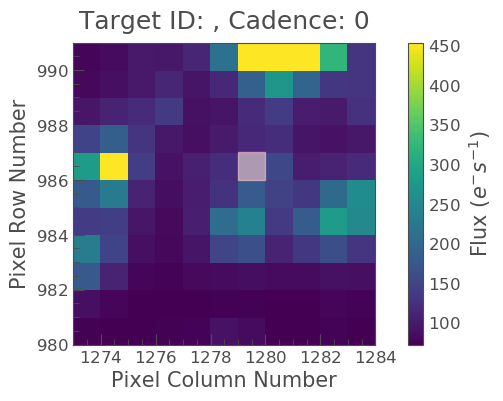

In [6]:
# Guess closest pixel
radecs = np.vstack([[tpf.ra], [tpf.dec]]).T
coords = tpf.wcs.all_world2pix(radecs, 0)

x=coords[:, 0]+tpf.column
x1=coords[:, 0]

y=coords[:, 1]+tpf.row
y1 = coords[:, 1]


masknear = np.zeros([11,11])
masknear[ceil(x1)][ceil(y1)] = 1.
maskneartoplot = masknear.astype(bool)
tpf.plot(aperture_mask=maskneartoplot)

# Guess closest Pixel

In [7]:
#If eleanor mask was found can do aperture_mask=data.aperture.astype(bool)

sourcelc = '{}Sector{}withBKLC.fits'.format(name,tpf.sector)
#tpf.interact(notebook_url='localhost:8888',exported_filename=sourcelc)
#tpf.interact(notebook_url='localhost:8888',exported_filename=sourcelc,aperture_mask=np.flip(dataeleanor.aperture.astype(bool),0))
tpf.interact(notebook_url='localhost:8888',exported_filename=sourcelc,aperture_mask=maskneartoplot)

In [8]:
tpf.interact_sky(magnitude_limit=20) 

In [9]:
background_mask = ~tpf.create_threshold_mask(threshold=0.0000001, reference_pixel=None)
#tpf.plot(aperture_mask=background_mask, mask_color='w');
n_background_pixels = background_mask.sum()
#print(n_background_pixels)
backgroundlc = '{}Sector{}BKLC.fits'.format(name,tpf.sector)

tpf.interact(notebook_url='localhost:8888',exported_filename=backgroundlc,aperture_mask=background_mask)

## Create a light-curve

Number of Background Pixels: 59


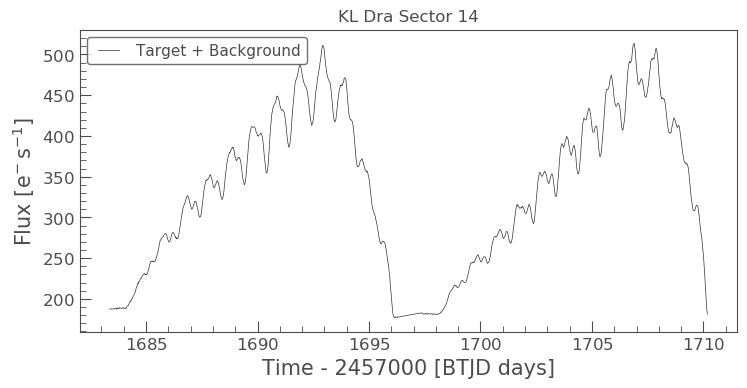

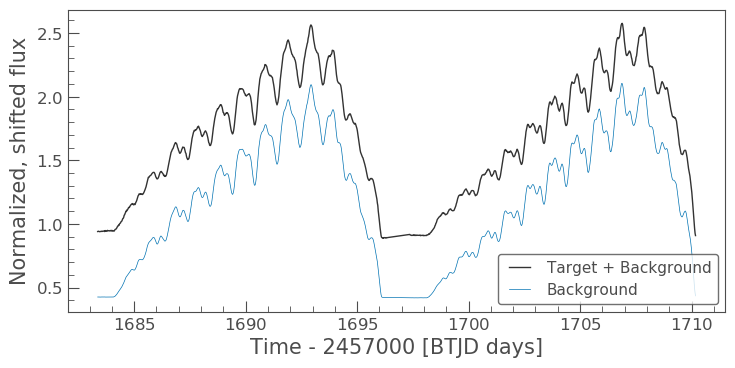

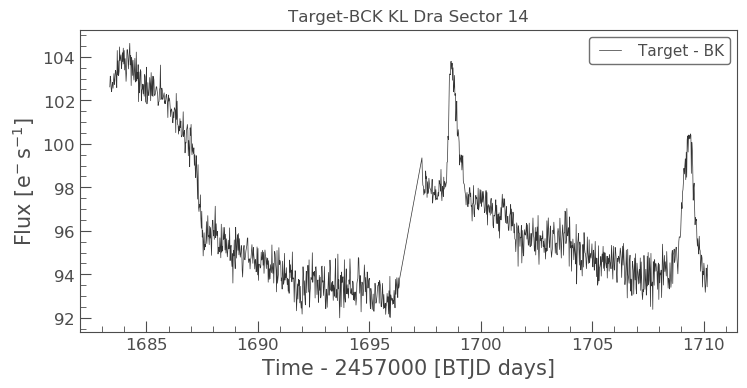

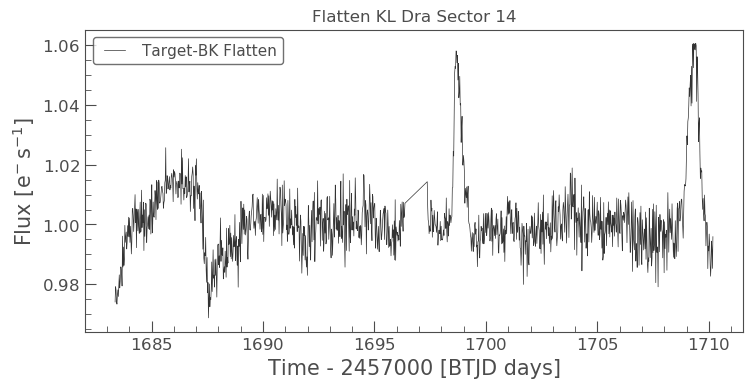

In [12]:
sourcemaskfits = fits.open(sourcelc)
sourcemask = sourcemaskfits[2].data
n_target_pixels = len(np.where(sourcemask==3)[0])

target_lc = tpf.to_lightcurve(aperture_mask=sourcemask)
target_lc.plot(label='Target + Background')
titleplot1 = '{} Sector {}'.format(name,sectornum)
plt.title(titleplot1)


#Backgorund
backgroundmaskfits = fits.open(backgroundlc)
backgroundmask = backgroundmaskfits[2].data
n_background_pixels = len(np.where(backgroundmask==3)[0])
background_lc_per_pixel = tpf.to_lightcurve(aperture_mask=backgroundmask) / n_background_pixels
print("Number of Background Pixels: {}".format(n_background_pixels))
background_estimate_lc = background_lc_per_pixel * n_target_pixels

# Substrtact background
common_normalization = np.nanpercentile(target_lc.flux, 10)
ax = (target_lc / common_normalization).plot(normalize=False, label='Target + Background', lw=1);
(background_estimate_lc / common_normalization +0).plot(ax=ax, normalize=False, label='Background',
                                                        ylabel='Normalized, shifted flux');


corrected_lc = target_lc - background_estimate_lc.flux
corrected_lc.plot(label='Target - BK');
plt.title('Target-BCK {} Sector {}'.format(name,sectornum))


#Remove low frequenbce
flat_lc = corrected_lc.flatten(window_length=401)
flat_lc.plot(label='Target-BK Flatten');
plt.title('Flatten {} Sector {}'.format(name,sectornum))



#Bokeh 
lcdic = {'time':corrected_lc.time,
        "flatflux":corrected_lc.flux,
        "mjdtimelc":corrected_lc.astropy_time.mjd}
source = ColumnDataSource(data=lcdic)

p = figure(plot_width=900, plot_height=500,title='Target-BCK {} Sector {}'.format(name,sectornum))
    

#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ('Date', '(@time{0,0.000})'),
            ("MJD",'(@mjdtimelc{00000.000})')
        ]
    )


p.add_tools(hover2)

p.line('time','flatflux',source=source)
show(p)


# With Eleanor

# Eleanor and tess y axis are flipped

Inflating...


/home/mmarcano/anaconda3/envs/eleanor/lib/python3.7/site-packages/eleanor/targetdata.py:383: UserWarning: WARNING: Making a TPF smaller than (9,9) may provide inadequate results.
  warnings.warn('WARNING: Making a TPF smaller than (9,9) may provide inadequate results.')
/home/mmarcano/anaconda3/envs/eleanor/lib/python3.7/site-packages/eleanor/targetdata.py:393: UserWarning: WARNING: Making a TPF smaller than (9,9) may provide inadequate results.
  warnings.warn('WARNING: Making a TPF smaller than (9,9) may provide inadequate results.')


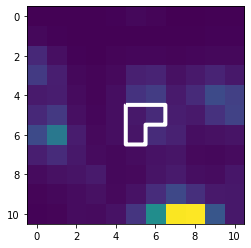

/home/mmarcano/anaconda3/envs/eleanor/lib/python3.7/site-packages/numpy/core/fromnumeric.py:745: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/mmarcano/anaconda3/envs/eleanor/lib/python3.7/site-packages/eleanor/visualize.py:214: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


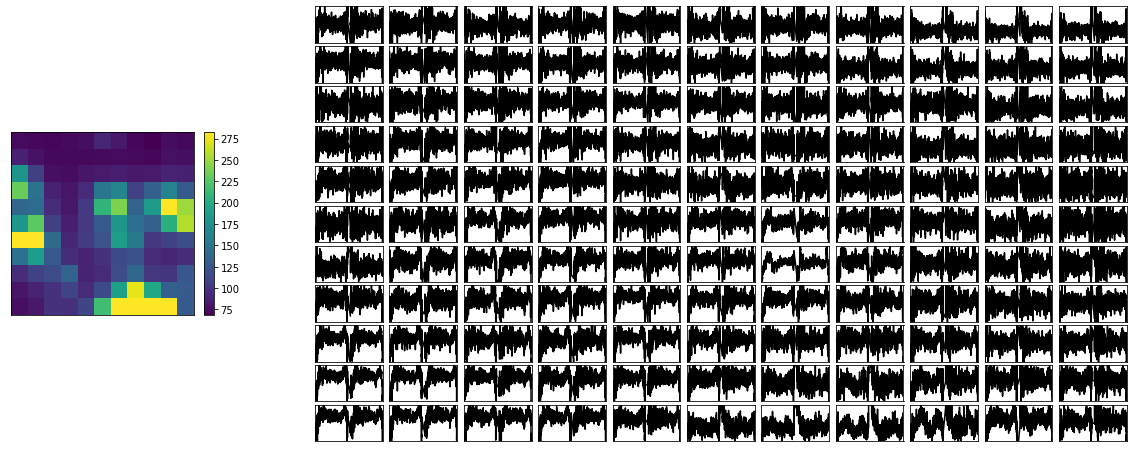

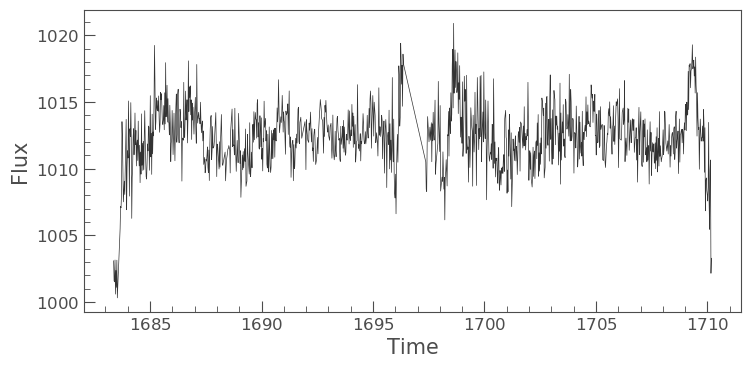

In [11]:
sectornum = 14
star = eleanor.Source(coords=(sourcetess['ra'],sourcetess['dec']), sector=sectornum, tc=True)
dataeleanor = eleanor.TargetData(star,height=11, width=11)

vis = eleanor.Visualize(dataeleanor)
vis.aperture_contour()

fig = vis.pixel_by_pixel()

q = dataeleanor.quality == 0
lkeleanor = LC(dataeleanor.time[q], dataeleanor.corr_flux[q]).plot()

#Bokeh 
lcdic = {'time':dataeleanor.time[q],
        "flatflux":dataeleanor.corr_flux[q]}
source = ColumnDataSource(data=lcdic)

p = figure(plot_width=900, plot_height=500,title='Eleanor Target-BCK {} Sector {}'.format(name,sectornum))
    

#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ('Date', '(@time{0,0.000})')
        ]
    )


p.add_tools(hover2)

p.line('time','flatflux',source=source)
show(p)

# Sector 15

In [13]:
sectornum = 15
#tpf = lk.search_tesscut(sourcecoord,sector=sectornum).download(cutout_size=11)

url = "https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra={ra}&dec={dec}&y=11&x=11&units=px&sector={sector}".format(ra=sourcetess['ra']
,dec=sourcetess['dec']
,sector=sectornum)
#tpf = lk.search_tesscut(sourcecoord,sector=sectornum).download(cutout_size=11)
response = urllib.request.urlretrieve(url,'TESSCUT.zip')
with ZipFile('TESSCUT.zip') as zipobj:
    zipobj.extractall()
    
for i in glob.glob('tess-s*.fits'):
    os.rename(i,'astrocut.fits')
    tpf = lk.TessTargetPixelFile('astrocut.fits')
    os.remove('astrocut.fits')
    os.remove('TESSCUT.zip')
    

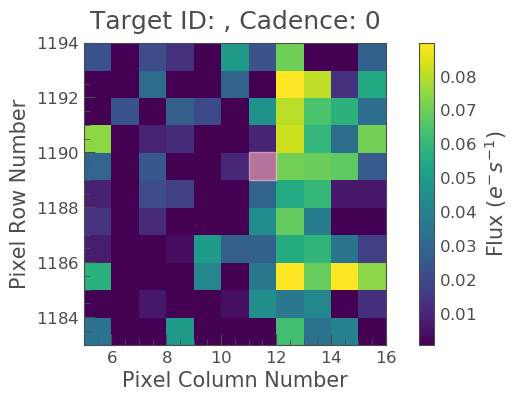

In [14]:
# Guess closest pixel
radecs = np.vstack([[tpf.ra], [tpf.dec]]).T
coords = tpf.wcs.all_world2pix(radecs, 0)

x=coords[:, 0]+tpf.column
x1=coords[:, 0]

y=coords[:, 1]+tpf.row
y1 = coords[:, 1]


masknear = np.zeros([11,11])
masknear[ceil(x1)][ceil(y1)] = 1.
maskneartoplot = masknear.astype(bool)
tpf.plot(aperture_mask=maskneartoplot)

In [15]:
#If eleanor mask was found can do aperture_mask=data.aperture.astype(bool)

sourcelc = '{}Sector{}withBKLC.fits'.format(name,tpf.sector)
#tpf.interact(notebook_url='localhost:8888',exported_filename=sourcelc)
tpf.interact(notebook_url='localhost:8888',exported_filename=sourcelc,aperture_mask=maskneartoplot)

In [16]:
tpf.interact_sky(magnitude_limit=20)

In [17]:
background_mask = ~tpf.create_threshold_mask(threshold=0.0000001, reference_pixel=None)
#tpf.plot(aperture_mask=background_mask, mask_color='w');
n_background_pixels = background_mask.sum()
#print(n_background_pixels)
backgroundlc = '{}Sector{}BKLC.fits'.format(name,tpf.sector)

tpf.interact(notebook_url='localhost:8888',exported_filename=backgroundlc,aperture_mask=background_mask)

## Create a light-curve

Number of Background Pixels: 61


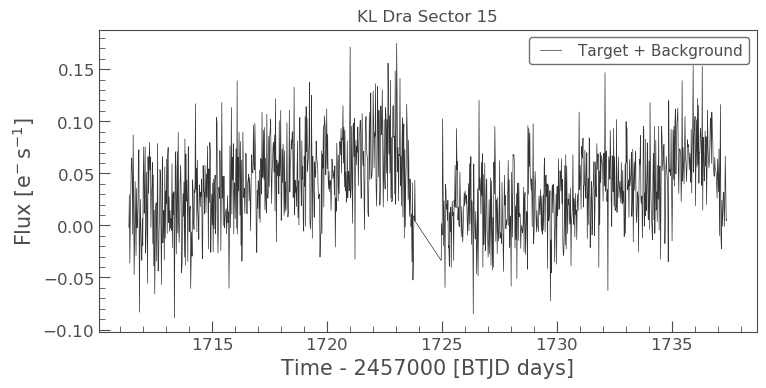

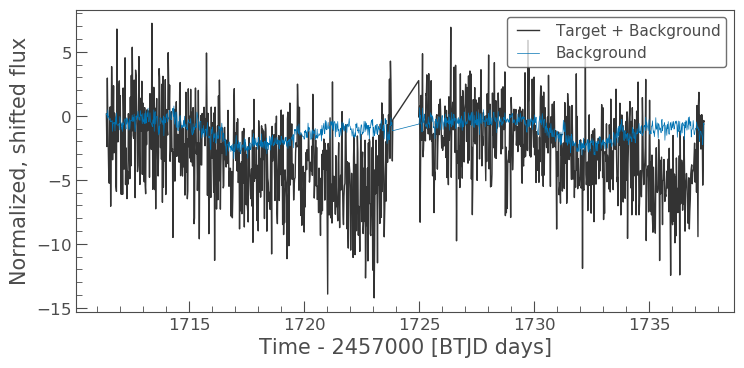

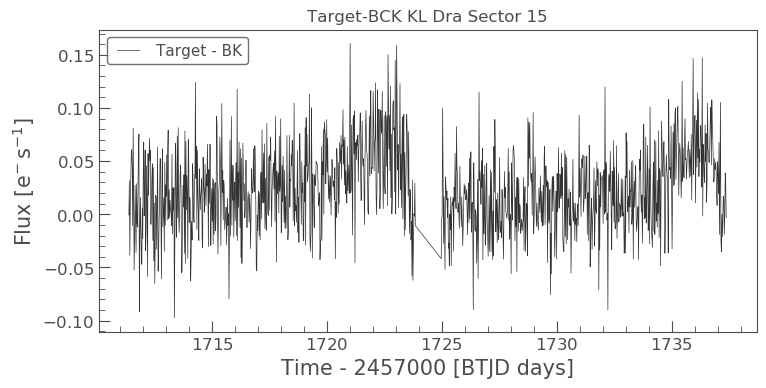

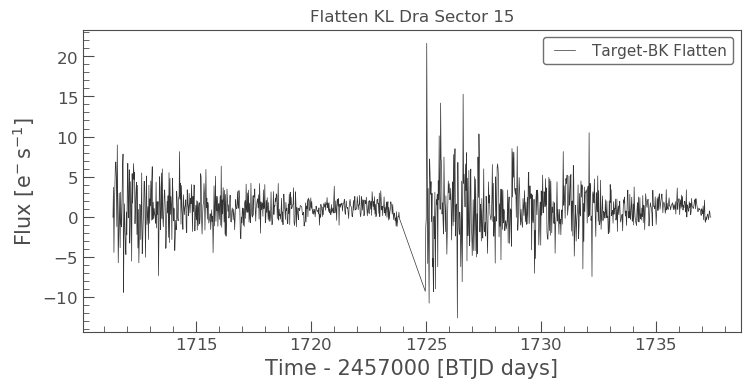

In [19]:
sourcemaskfits = fits.open(sourcelc)
sourcemask = sourcemaskfits[2].data
n_target_pixels = len(np.where(sourcemask==3)[0])

target_lc = tpf.to_lightcurve(aperture_mask=sourcemask)
target_lc.plot(label='Target + Background')
titleplot1 = '{} Sector {}'.format(name,sectornum)
plt.title(titleplot1)


#Backgorund
backgroundmaskfits = fits.open(backgroundlc)
backgroundmask = backgroundmaskfits[2].data
n_background_pixels = len(np.where(backgroundmask==3)[0])
background_lc_per_pixel = tpf.to_lightcurve(aperture_mask=backgroundmask) / n_background_pixels
print("Number of Background Pixels: {}".format(n_background_pixels))
background_estimate_lc = background_lc_per_pixel * n_target_pixels

# Substrtact background
common_normalization = np.nanpercentile(target_lc.flux, 10)
ax = (target_lc / common_normalization).plot(normalize=False, label='Target + Background', lw=1);
(background_estimate_lc / common_normalization +0).plot(ax=ax, normalize=False, label='Background',
                                                        ylabel='Normalized, shifted flux');


corrected_lc = target_lc - background_estimate_lc.flux
corrected_lc.plot(label='Target - BK');
plt.title('Target-BCK {} Sector {}'.format(name,sectornum))


#Remove low frequenbce
flat_lc = corrected_lc.flatten(window_length=401)
flat_lc.plot(label='Target-BK Flatten');
plt.title('Flatten {} Sector {}'.format(name,sectornum))



#Bokeh 
lcdic = {'time':corrected_lc.time,
        "flatflux":corrected_lc.flux,
        "mjdtimelc":corrected_lc.astropy_time.mjd}
source = ColumnDataSource(data=lcdic)

p = figure(plot_width=900, plot_height=500,title='Target-BCK {} Sector {}'.format(name,sectornum))
    

#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ('Date', '(@time{0,0.000})'),
            ("MJD",'(@mjdtimelc{00000.000})')
        ]
    )


p.add_tools(hover2)

p.line('time','flatflux',source=source)
show(p)


# With Eleanor

# Eleanor and tess y axis are flipped

Inflating...


/home/mmarcano/anaconda3/envs/eleanor/lib/python3.7/site-packages/eleanor/targetdata.py:383: UserWarning: WARNING: Making a TPF smaller than (9,9) may provide inadequate results.
  warnings.warn('WARNING: Making a TPF smaller than (9,9) may provide inadequate results.')
/home/mmarcano/anaconda3/envs/eleanor/lib/python3.7/site-packages/eleanor/targetdata.py:393: UserWarning: WARNING: Making a TPF smaller than (9,9) may provide inadequate results.
  warnings.warn('WARNING: Making a TPF smaller than (9,9) may provide inadequate results.')


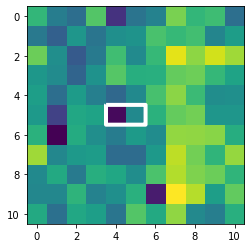

/home/mmarcano/anaconda3/envs/eleanor/lib/python3.7/site-packages/numpy/core/fromnumeric.py:745: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/mmarcano/anaconda3/envs/eleanor/lib/python3.7/site-packages/eleanor/visualize.py:214: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


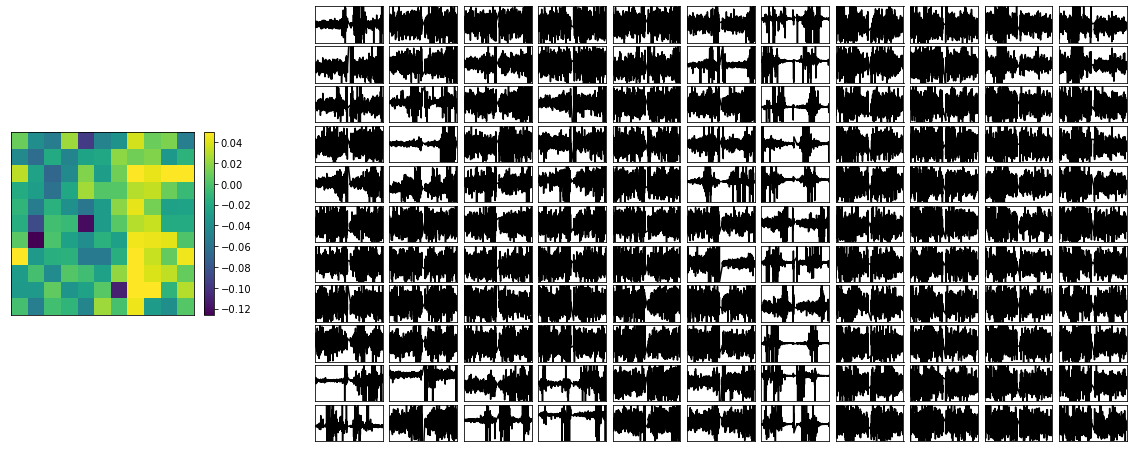

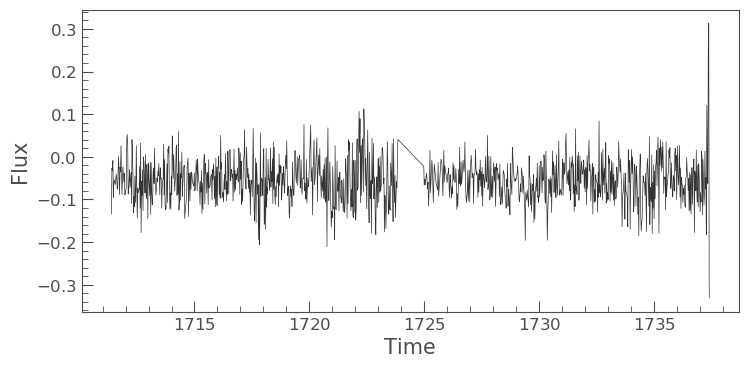

In [20]:
sectornum = 15
star = eleanor.Source(coords=(sourcetess['ra'],sourcetess['dec']), sector=sectornum, tc=True)
dataeleanor = eleanor.TargetData(star,height=11, width=11)

vis = eleanor.Visualize(dataeleanor)
vis.aperture_contour()

fig = vis.pixel_by_pixel()

q = dataeleanor.quality == 0
lkeleanor = LC(dataeleanor.time[q], dataeleanor.corr_flux[q]).plot()

#Bokeh 
lcdic = {'time':dataeleanor.time[q],
        "flatflux":dataeleanor.corr_flux[q]}
source = ColumnDataSource(data=lcdic)

p = figure(plot_width=900, plot_height=500,title='Eleanor Target-BCK {} Sector {}'.format(name,sectornum))
    

#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ('Date', '(@time{0,0.000})')
        ]
    )


p.add_tools(hover2)

p.line('time','flatflux',source=source)
show(p)

# Sector 16

In [24]:
sectornum = 16
#tpf = lk.search_tesscut(sourcecoord,sector=sectornum).download(cutout_size=11)

url = "https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra={ra}&dec={dec}&y=11&x=11&units=px&sector={sector}".format(ra=sourcetess['ra']
,dec=sourcetess['dec']
,sector=sectornum)
#tpf = lk.search_tesscut(sourcecoord,sector=sectornum).download(cutout_size=11)
response = urllib.request.urlretrieve(url,'TESSCUT.zip')
with ZipFile('TESSCUT.zip') as zipobj:
    zipobj.extractall()
    
for i in glob.glob('tess-s*.fits'):
    os.rename(i,'astrocut.fits')
    tpf = lk.TessTargetPixelFile('astrocut.fits')
    os.remove('astrocut.fits')
    os.remove('TESSCUT.zip')
    

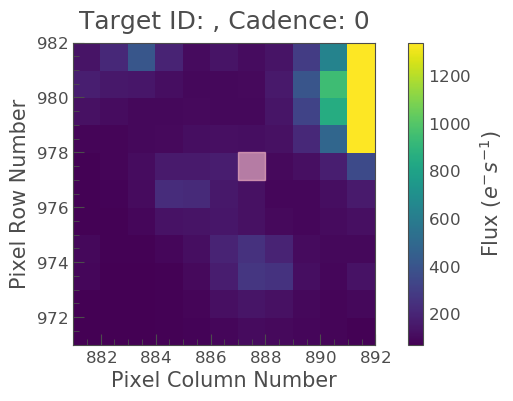

In [29]:
# Guess closest pixel
radecs = np.vstack([[tpf.ra], [tpf.dec]]).T
coords = tpf.wcs.all_world2pix(radecs, 0)

x=coords[:, 0]+tpf.column
x1=coords[:, 0]

y=coords[:, 1]+tpf.row
y1 = coords[:, 1]


masknear = np.zeros([11,11])
masknear[ceil(x1)][ceil(y1)] = 1.
maskneartoplot = masknear.astype(bool)
tpf.plot(aperture_mask=maskneartoplot)

In [46]:
#If eleanor mask was found can do aperture_mask=data.aperture.astype(bool)

sourcelc = '{}Sector{}withBKLC.fits'.format(name,tpf.sector)
#tpf.interact(notebook_url='localhost:8888',exported_filename=sourcelc)
tpf.interact(notebook_url='localhost:8888',exported_filename=sourcelc,aperture_mask=maskneartoplot)

In [31]:
tpf.interact_sky(magnitude_limit=20)

In [32]:
background_mask = ~tpf.create_threshold_mask(threshold=0.0000001, reference_pixel=None)
#tpf.plot(aperture_mask=background_mask, mask_color='w');
n_background_pixels = background_mask.sum()
#print(n_background_pixels)
backgroundlc = '{}Sector{}BKLC.fits'.format(name,tpf.sector)

tpf.interact(notebook_url='localhost:8888',exported_filename=backgroundlc,aperture_mask=background_mask)

## Create a light-curve

Number of Background Pixels: 58


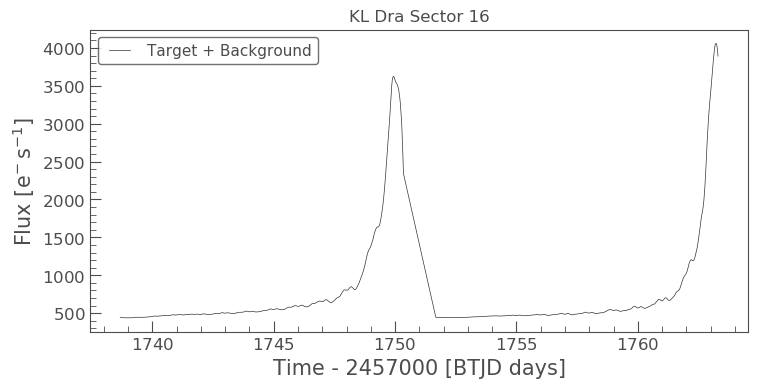

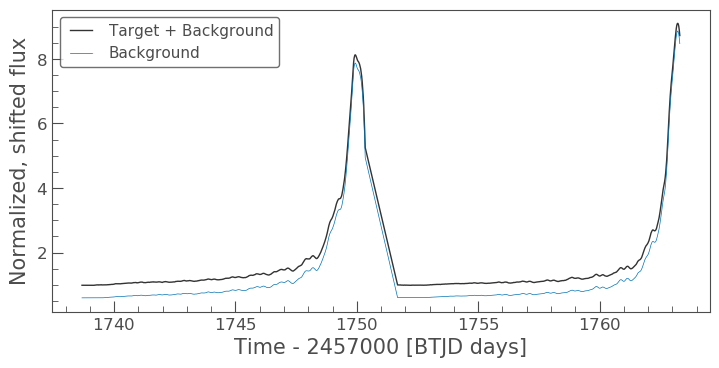

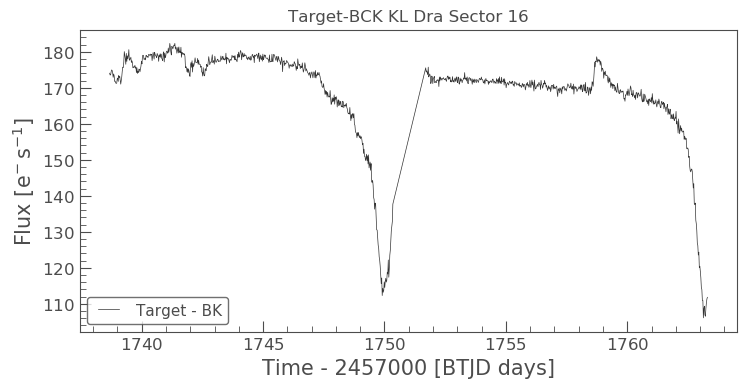

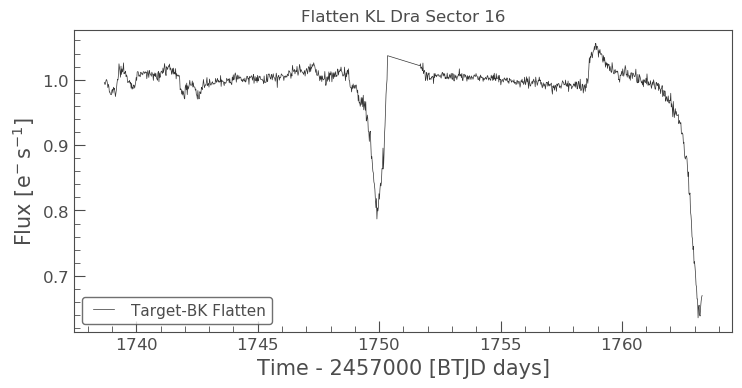

In [54]:
sourcemaskfits = fits.open(sourcelc)
sourcemask = sourcemaskfits[2].data
n_target_pixels = len(np.where(sourcemask==3)[0])

target_lc = tpf.to_lightcurve(aperture_mask=sourcemask)
target_lc.plot(label='Target + Background')
titleplot1 = '{} Sector {}'.format(name,sectornum)
plt.title(titleplot1)


#Backgorund
backgroundmaskfits = fits.open(backgroundlc)
backgroundmask = backgroundmaskfits[2].data
n_background_pixels = len(np.where(backgroundmask==3)[0])
background_lc_per_pixel = tpf.to_lightcurve(aperture_mask=backgroundmask) / n_background_pixels
print("Number of Background Pixels: {}".format(n_background_pixels))
background_estimate_lc = background_lc_per_pixel * n_target_pixels

# Substrtact background
common_normalization = np.nanpercentile(target_lc.flux, 10)
ax = (target_lc / common_normalization).plot(normalize=False, label='Target + Background', lw=1);
(background_estimate_lc / common_normalization +0).plot(ax=ax, normalize=False, label='Background',
                                                        ylabel='Normalized, shifted flux');


corrected_lc = target_lc - background_estimate_lc.flux
corrected_lc.plot(label='Target - BK');
plt.title('Target-BCK {} Sector {}'.format(name,sectornum))


#Remove low frequenbce
flat_lc = corrected_lc.flatten(window_length=401)
flat_lc.plot(label='Target-BK Flatten');
plt.title('Flatten {} Sector {}'.format(name,sectornum))



#Bokeh 
lcdic = {'time':corrected_lc.time,
        "flatflux":corrected_lc.flux,
        "mjdtimelc":corrected_lc.astropy_time.mjd}
source = ColumnDataSource(data=lcdic)

p = figure(plot_width=900, plot_height=500,title='Target-BCK {} Sector {}'.format(name,sectornum))
    

#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ('Date', '(@time{0,0.000})'),
            ("MJD",'(@mjdtimelc{00000.000})')
        ]
    )


p.add_tools(hover2)

p.line('time','flatflux',source=source)
show(p)


In [36]:
timelc = corrected_lc.astropy_time

In [37]:
timelc

<Time object: scale='tdb' format='jd' value=[2458738.6786499  2458738.69952393 2458738.72033691 ... 2458763.26171875
 2458763.28253174 2458763.30340576]>

In [38]:
initlc, endlc = timelc[0], timelc[-1]

In [39]:
initlc.iso, initlc.mjd.iso

('2019-09-12 04:17:15.352', '2019-10-06 19:16:54.258')

In [40]:
print(initlc.mjd,endlc.mjd)

58738.178649902344 58762.80340576172


# With Eleanor

# Eleanor and tess y axis are flipped

/home/mmarcano/anaconda3/envs/eleanor/lib/python3.7/site-packages/eleanor/targetdata.py:383: UserWarning: WARNING: Making a TPF smaller than (9,9) may provide inadequate results.
  warnings.warn('WARNING: Making a TPF smaller than (9,9) may provide inadequate results.')
/home/mmarcano/anaconda3/envs/eleanor/lib/python3.7/site-packages/eleanor/targetdata.py:393: UserWarning: WARNING: Making a TPF smaller than (9,9) may provide inadequate results.
  warnings.warn('WARNING: Making a TPF smaller than (9,9) may provide inadequate results.')


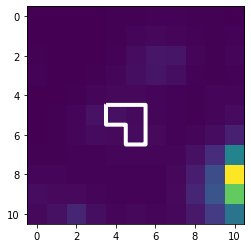

/home/mmarcano/anaconda3/envs/eleanor/lib/python3.7/site-packages/numpy/core/fromnumeric.py:745: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/mmarcano/anaconda3/envs/eleanor/lib/python3.7/site-packages/eleanor/visualize.py:214: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


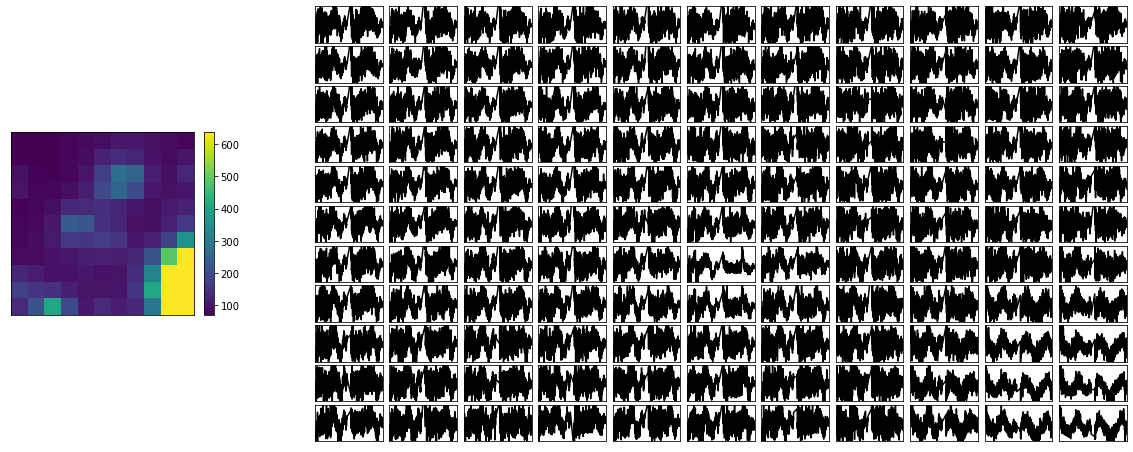

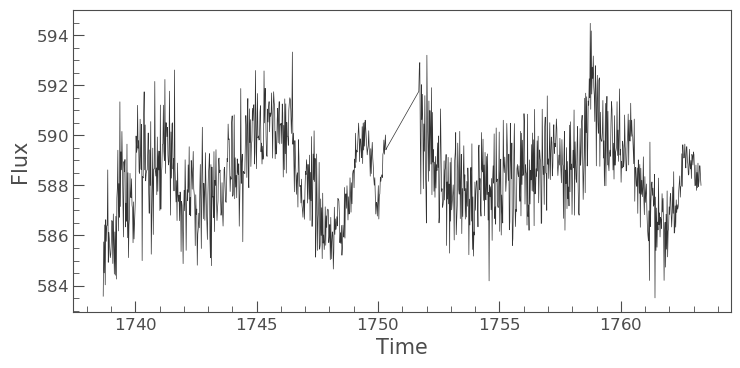

In [55]:
sectornum = 16
star = eleanor.Source(coords=(sourcetess['ra'],sourcetess['dec']), sector=sectornum, tc=True)
dataeleanor = eleanor.TargetData(star,height=11, width=11)

vis = eleanor.Visualize(dataeleanor)
vis.aperture_contour()

fig = vis.pixel_by_pixel()

q = dataeleanor.quality == 0
lkeleanor = LC(dataeleanor.time[q], dataeleanor.corr_flux[q]).plot()

#Bokeh 
lcdic = {'time':dataeleanor.time[q],
        "flatflux":dataeleanor.corr_flux[q]}
source = ColumnDataSource(data=lcdic)

p = figure(plot_width=900, plot_height=500,title='Eleanor Target-BCK {} Sector {}'.format(name,sectornum))
    

#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ('Date', '(@time{0,0.000})')
        ]
    )


p.add_tools(hover2)

p.line('time','flatflux',source=source)
show(p)

# Other Sector

In [56]:
sectornum = 17
#tpf = lk.search_tesscut(sourcecoord,sector=sectornum).download(cutout_size=11)

url = "https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra={ra}&dec={dec}&y=11&x=11&units=px&sector={sector}".format(ra=sourcetess['ra']
,dec=sourcetess['dec']
,sector=sectornum)
#tpf = lk.search_tesscut(sourcecoord,sector=sectornum).download(cutout_size=11)
response = urllib.request.urlretrieve(url,'TESSCUT.zip')
with ZipFile('TESSCUT.zip') as zipobj:
    zipobj.extractall()
    
for i in glob.glob('tess-s*.fits'):
    os.rename(i,'astrocut.fits')
    tpf = lk.TessTargetPixelFile('astrocut.fits')
    os.remove('astrocut.fits')
    os.remove('TESSCUT.zip')
    


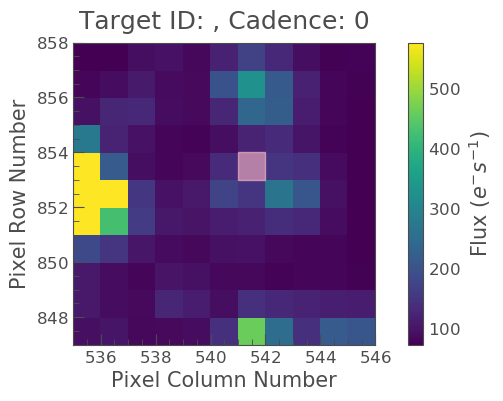

In [57]:
# Guess closest pixel
radecs = np.vstack([[tpf.ra], [tpf.dec]]).T
coords = tpf.wcs.all_world2pix(radecs, 0)

x=coords[:, 0]+tpf.column
x1=coords[:, 0]

y=coords[:, 1]+tpf.row
y1 = coords[:, 1]


masknear = np.zeros([11,11])
masknear[ceil(x1)][ceil(y1)] = 1.
maskneartoplot = masknear.astype(bool)
tpf.plot(aperture_mask=maskneartoplot)

In [80]:
#If eleanor mask was found can do aperture_mask=data.aperture.astype(bool)

sourcelc = '{}Sector{}withBKLC.fits'.format(name,tpf.sector)
#tpf.interact(notebook_url='localhost:8888',exported_filename=sourcelc)
tpf.interact(notebook_url='localhost:8888',exported_filename=sourcelc,aperture_mask=maskneartoplot)

In [59]:
tpf.interact_sky(magnitude_limit=20)

In [60]:
background_mask = ~tpf.create_threshold_mask(threshold=0.0000001, reference_pixel=None)
#tpf.plot(aperture_mask=background_mask, mask_color='w');
n_background_pixels = background_mask.sum()
#print(n_background_pixels)
backgroundlc = '{}Sector{}BKLC.fits'.format(name,tpf.sector)

tpf.interact(notebook_url='localhost:8888',exported_filename=backgroundlc,aperture_mask=background_mask)

## Create a light-curve

Number of Background Pixels: 61


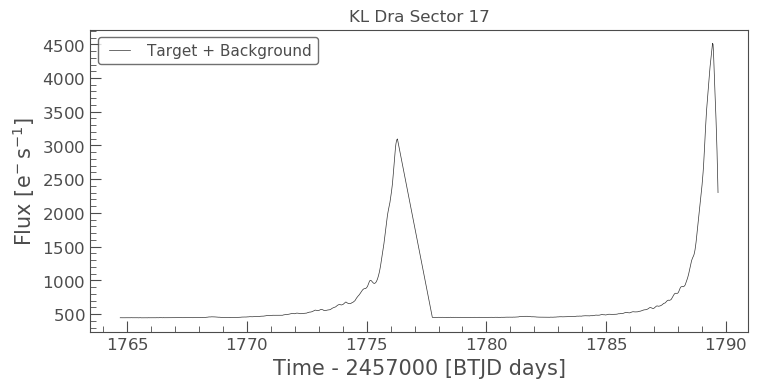

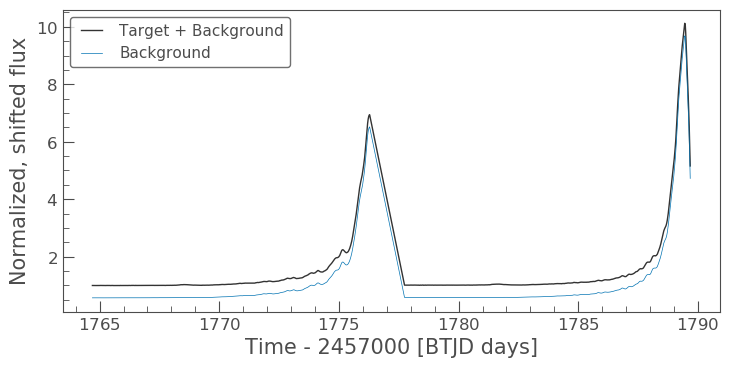

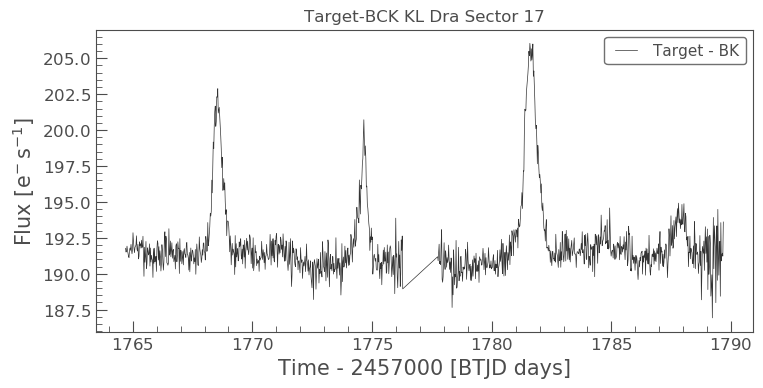

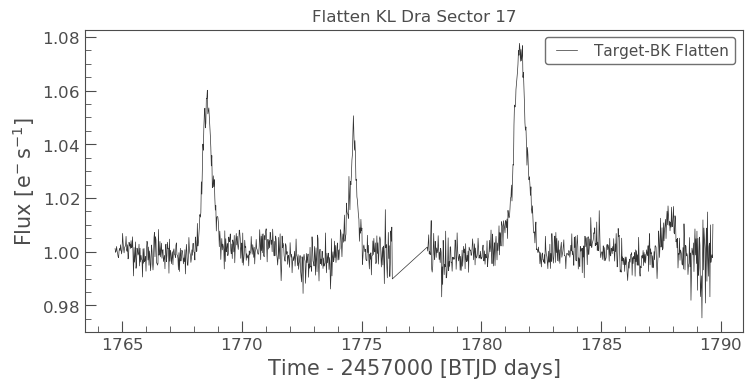

In [81]:
sourcemaskfits = fits.open(sourcelc)
sourcemask = sourcemaskfits[2].data
n_target_pixels = len(np.where(sourcemask==3)[0])

target_lc = tpf.to_lightcurve(aperture_mask=sourcemask)
target_lc.plot(label='Target + Background')
titleplot1 = '{} Sector {}'.format(name,sectornum)
plt.title(titleplot1)


#Backgorund
backgroundmaskfits = fits.open(backgroundlc)
backgroundmask = backgroundmaskfits[2].data
n_background_pixels = len(np.where(backgroundmask==3)[0])
background_lc_per_pixel = tpf.to_lightcurve(aperture_mask=backgroundmask) / n_background_pixels
print("Number of Background Pixels: {}".format(n_background_pixels))
background_estimate_lc = background_lc_per_pixel * n_target_pixels

# Substrtact background
common_normalization = np.nanpercentile(target_lc.flux, 10)
ax = (target_lc / common_normalization).plot(normalize=False, label='Target + Background', lw=1);
(background_estimate_lc / common_normalization +0).plot(ax=ax, normalize=False, label='Background',
                                                        ylabel='Normalized, shifted flux');


corrected_lc = target_lc - background_estimate_lc.flux
corrected_lc.plot(label='Target - BK');
plt.title('Target-BCK {} Sector {}'.format(name,sectornum))


#Remove low frequenbce
flat_lc = corrected_lc.flatten(window_length=401)
flat_lc.plot(label='Target-BK Flatten');
plt.title('Flatten {} Sector {}'.format(name,sectornum))



#Bokeh 
lcdic = {'time':corrected_lc.time,
        "flatflux":corrected_lc.flux,
        "mjdtimelc":corrected_lc.astropy_time.mjd}
source = ColumnDataSource(data=lcdic)

p = figure(plot_width=900, plot_height=500,title='Target-BCK {} Sector {}'.format(name,sectornum))
    

#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ('Date', '(@time{0,0.000})'),
            ("MJD",'(@mjdtimelc{00000.000})')
        ]
    )


p.add_tools(hover2)

p.line('time','flatflux',source=source)
show(p)


In [73]:
timelc = corrected_lc.astropy_time

In [74]:
timelc

<Time object: scale='tdb' format='jd' value=[2458764.69903564 2458764.71990967 2458764.74072266 ... 2458789.6362915
 2458789.65710449 2458789.67791748]>

In [75]:
initlc, endlc = timelc[0], timelc[-1]

In [77]:
print(initlc.mjd,endlc.mjd)

58764.19903564453 58789.17791748047


# With Eleanor

# Eleanor and tess y axis are flipped

In [78]:
sectornum = 17
star = eleanor.Source(coords=(sourcetess['ra'],sourcetess['dec']), sector=sectornum, tc=True)
dataeleanor = eleanor.TargetData(star,height=11, width=11)

vis = eleanor.Visualize(dataeleanor)
vis.aperture_contour()

fig = vis.pixel_by_pixel()

%matplotlib inline
q = dataeleanor.quality == 0
lkeleanor = LC(dataeleanor.time[q], dataeleanor.corr_flux[q]).plot()

#Bokeh 
lcdic = {'time':dataeleanor.time[q],
        "flatflux":dataeleanor.corr_flux[q]}
source = ColumnDataSource(data=lcdic)

p = figure(plot_width=900, plot_height=500,title='Eleanor Target-BCK {} Sector {}'.format(name,sectornum))
    

#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ('Date', '(@time{0,0.000})')
        ]
    )


p.add_tools(hover2)

p.line('time','flatflux',source=source)
show(p)

HTTPError: HTTP Error 404: Not Found

/home/mmarcano/anaconda3/envs/eleanor/lib/python3.7/site-packages/numpy/core/fromnumeric.py:745: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/mmarcano/anaconda3/envs/eleanor/lib/python3.7/site-packages/eleanor/visualize.py:214: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


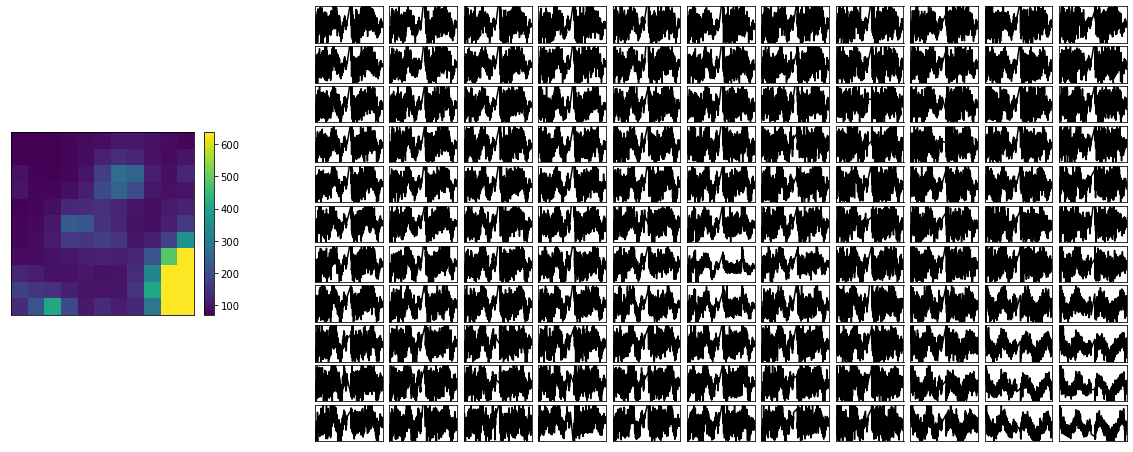

In [240]:
fig = vis.pixel_by_pixel()

# SEctor 18

In [82]:
sectornum = 18
#tpf = lk.search_tesscut(sourcecoord,sector=sectornum).download(cutout_size=11)

url = "https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra={ra}&dec={dec}&y=11&x=11&units=px&sector={sector}".format(ra=sourcetess['ra']
,dec=sourcetess['dec']
,sector=sectornum)
#tpf = lk.search_tesscut(sourcecoord,sector=sectornum).download(cutout_size=11)
response = urllib.request.urlretrieve(url,'TESSCUT.zip')
with ZipFile('TESSCUT.zip') as zipobj:
    zipobj.extractall()
    
for i in glob.glob('tess-s*.fits'):
    os.rename(i,'astrocut.fits')
    tpf = lk.TessTargetPixelFile('astrocut.fits')
    os.remove('astrocut.fits')
    os.remove('TESSCUT.zip')
    





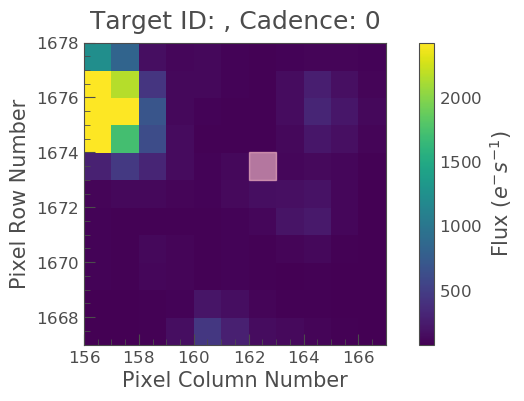

In [83]:
# Guess closest pixel
radecs = np.vstack([[tpf.ra], [tpf.dec]]).T
coords = tpf.wcs.all_world2pix(radecs, 0)

x=coords[:, 0]+tpf.column
x1=coords[:, 0]

y=coords[:, 1]+tpf.row
y1 = coords[:, 1]


masknear = np.zeros([11,11])
masknear[ceil(x1)][ceil(y1)] = 1.
maskneartoplot = masknear.astype(bool)
tpf.plot(aperture_mask=maskneartoplot)

In [98]:
#If eleanor mask was found can do aperture_mask=data.aperture.astype(bool)

sourcelc = '{}Sector{}withBKLC.fits'.format(name,tpf.sector)
#tpf.interact(notebook_url='localhost:8888',exported_filename=sourcelc)
tpf.interact(notebook_url='localhost:8888',exported_filename=sourcelc,aperture_mask=maskneartoplot)

In [85]:
tpf.interact_sky(magnitude_limit=20)

In [86]:
background_mask = ~tpf.create_threshold_mask(threshold=0.0000001, reference_pixel=None)
#tpf.plot(aperture_mask=background_mask, mask_color='w');
n_background_pixels = background_mask.sum()
#print(n_background_pixels)
backgroundlc = '{}Sector{}BKLC.fits'.format(name,tpf.sector)

tpf.interact(notebook_url='localhost:8888',exported_filename=backgroundlc,aperture_mask=background_mask)

## Create a light-curve

Number of Background Pixels: 4


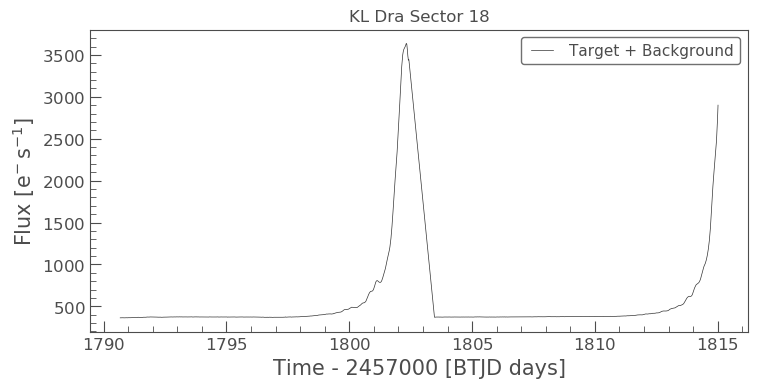

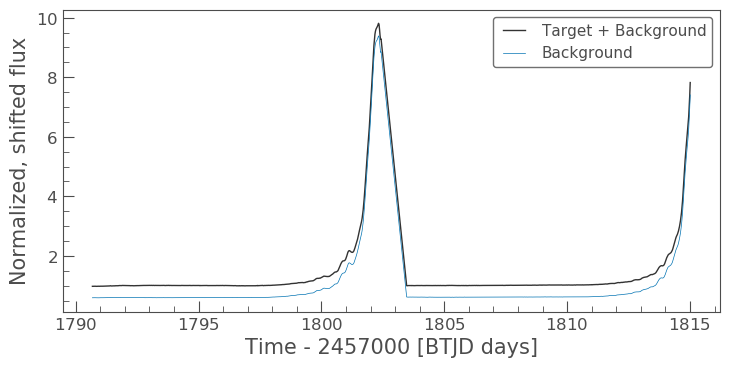

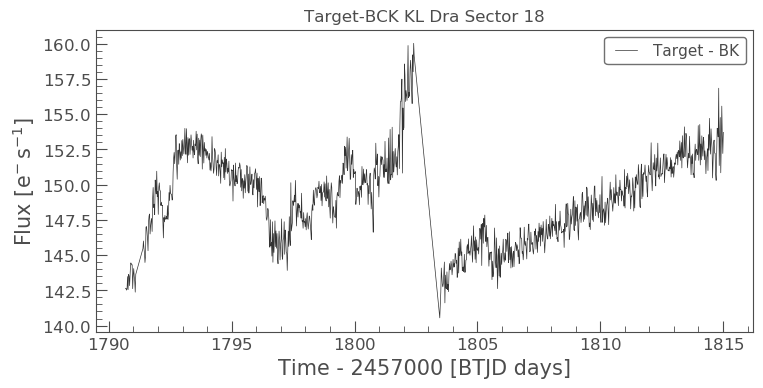

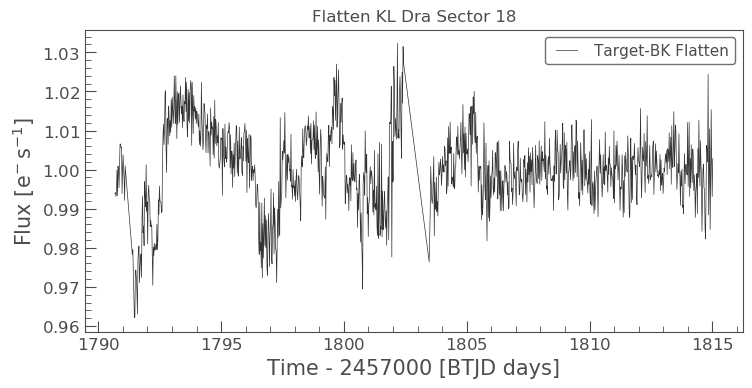

In [99]:
sourcemaskfits = fits.open(sourcelc)
sourcemask = sourcemaskfits[2].data
n_target_pixels = len(np.where(sourcemask==3)[0])

target_lc = tpf.to_lightcurve(aperture_mask=sourcemask)
target_lc.plot(label='Target + Background')
titleplot1 = '{} Sector {}'.format(name,sectornum)
plt.title(titleplot1)


#Backgorund
backgroundmaskfits = fits.open(backgroundlc)
backgroundmask = backgroundmaskfits[2].data
n_background_pixels = len(np.where(backgroundmask==3)[0])
background_lc_per_pixel = tpf.to_lightcurve(aperture_mask=backgroundmask) / n_background_pixels
print("Number of Background Pixels: {}".format(n_background_pixels))
background_estimate_lc = background_lc_per_pixel * n_target_pixels

# Substrtact background
common_normalization = np.nanpercentile(target_lc.flux, 10)
ax = (target_lc / common_normalization).plot(normalize=False, label='Target + Background', lw=1);
(background_estimate_lc / common_normalization +0).plot(ax=ax, normalize=False, label='Background',
                                                        ylabel='Normalized, shifted flux');


corrected_lc = target_lc - background_estimate_lc.flux
corrected_lc.plot(label='Target - BK');
plt.title('Target-BCK {} Sector {}'.format(name,sectornum))


#Remove low frequenbce
flat_lc = corrected_lc.flatten(window_length=401)
flat_lc.plot(label='Target-BK Flatten');
plt.title('Flatten {} Sector {}'.format(name,sectornum))



#Bokeh 
lcdic = {'time':corrected_lc.time,
        "flatflux":corrected_lc.flux,
        "mjdtimelc":corrected_lc.astropy_time.mjd}
source = ColumnDataSource(data=lcdic)

p = figure(plot_width=900, plot_height=500,title='Target-BCK {} Sector {}'.format(name,sectornum))
    

#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ('Date', '(@time{0,0.000})'),
            ("MJD",'(@mjdtimelc{00000.000})')
        ]
    )


p.add_tools(hover2)

p.line('time','flatflux',source=source)
show(p)


In [89]:
timelc = corrected_lc.astropy_time

In [90]:
timelc

<Time object: scale='tdb' format='jd' value=[2458790.67822266 2458790.69903564 2458790.71990967 ... 2458814.96960449
 2458814.99041748 2458815.0112915 ]>

In [91]:
initlc, endlc = timelc[0], timelc[-1]

In [92]:
print(initlc.mjd,endlc.mjd)

58790.17822265625 58814.511291503906


# With Eleanor

# Eleanor and tess y axis are flipped

In [97]:
sectornum = 18
star = eleanor.Source(coords=(sourcetess['ra'],sourcetess['dec']), sector=sectornum, tc=False)
dataeleanor = eleanor.TargetData(star,height=11, width=11)

SearchError: Sorry, this sector isn't available yet. We're working on it!

In [ ]:
vis = eleanor.Visualize(dataeleanor)
vis.aperture_contour()

In [ ]:
fig = vis.pixel_by_pixel()

In [ ]:
cross = eleanor.Crossmatch(dataeleanor)


In [ ]:
cross.two_minute()

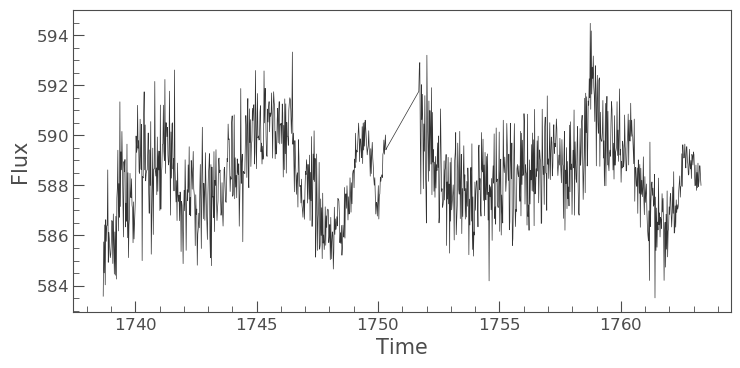

In [91]:
%matplotlib inline
q = dataeleanor.quality == 0
lkeleanor = LC(dataeleanor.time[q], dataeleanor.corr_flux[q]).plot()

#Bokeh 
lcdic = {'time':dataeleanor.time[q],
        "flatflux":dataeleanor.corr_flux[q]}
source = ColumnDataSource(data=lcdic)

p = figure(plot_width=900, plot_height=500,title='Eleanor Target-BCK {} Sector {}'.format(name,sectornum))
    

#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ('Date', '(@time{0,0.000})')
        ]
    )


p.add_tools(hover2)

p.line('time','flatflux',source=source)
show(p)

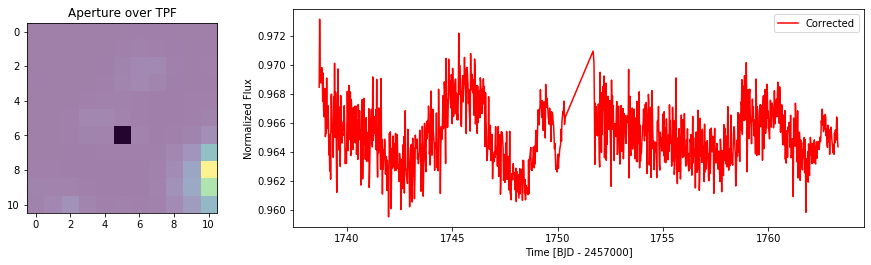

In [103]:
dataeleanor.get_lightcurve(aperture=sourcemask)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4), gridspec_kw={'width_ratios':[1,3]})
ax1.imshow(dataeleanor.tpf[0])
ax1.imshow(sourcemask, cmap='Greys', alpha=0.5)
ax1.set_title('Aperture over TPF')
#plt.imshow(dataeleanor.aperture)

#ax2.plot(dataeleanor.time[q], dataeleanor.raw_flux[q]/np.nanmedian(dataeleanor.raw_flux[q]), 'k', label='Raw')
ax2.plot(dataeleanor.time[q], dataeleanor.corr_flux[q]/np.nanmedian(dataeleanor.corr_flux[q]) - 0.035, 'r', label='Corrected')
ax2.legend()
ax2.set_xlabel('Time [BJD - 2457000]')
ax2.set_ylabel('Normalized Flux');

# Sector 19

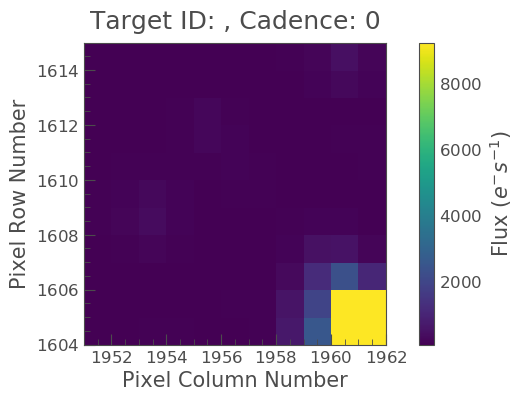

In [100]:
sectornum = 19
#tpf = lk.search_tesscut(sourcecoord,sector=sectornum).download(cutout_size=11)

url = "https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra={ra}&dec={dec}&y=11&x=11&units=px&sector={sector}".format(ra=sourcetess['ra']
,dec=sourcetess['dec']
,sector=sectornum)
#tpf = lk.search_tesscut(sourcecoord,sector=sectornum).download(cutout_size=11)
response = urllib.request.urlretrieve(url,'TESSCUT.zip')
with ZipFile('TESSCUT.zip') as zipobj:
    zipobj.extractall()
    
for i in glob.glob('tess-s*.fits'):
    os.rename(i,'astrocut.fits')
    tpf = lk.TessTargetPixelFile('astrocut.fits')
    os.remove('astrocut.fits')
    os.remove('TESSCUT.zip')
    



tpf.plot()

In [106]:
#If eleanor mask was found can do aperture_mask=data.aperture.astype(bool)

sourcelc = '{}Sector{}withBKLC.fits'.format(name,tpf.sector)
#tpf.interact(notebook_url='localhost:8888',exported_filename=sourcelc)
tpf.interact(notebook_url='localhost:8888',exported_filename=sourcelc,aperture_mask=dataeleanor.aperture.astype(bool))

In [102]:
tpf.interact_sky(magnitude_limit=20)

In [107]:
background_mask = ~tpf.create_threshold_mask(threshold=0.0000001, reference_pixel=None)
#tpf.plot(aperture_mask=background_mask, mask_color='w');
n_background_pixels = background_mask.sum()
#print(n_background_pixels)
backgroundlc = '{}Sector{}BKLC.fits'.format(name,tpf.sector)

tpf.interact(notebook_url='localhost:8888',exported_filename=backgroundlc,aperture_mask=background_mask)

## Create a light-curve

Number of Background Pixels: 61


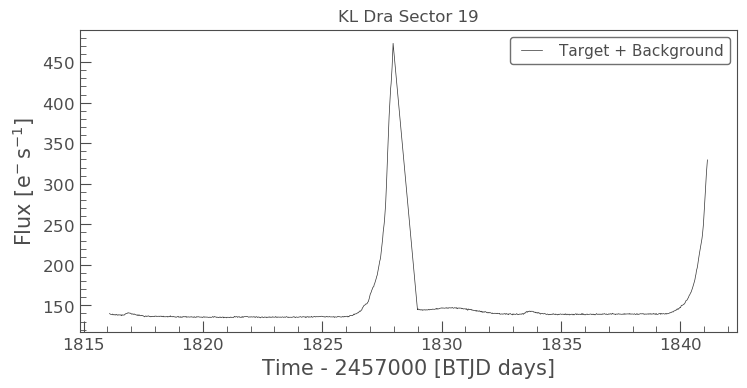

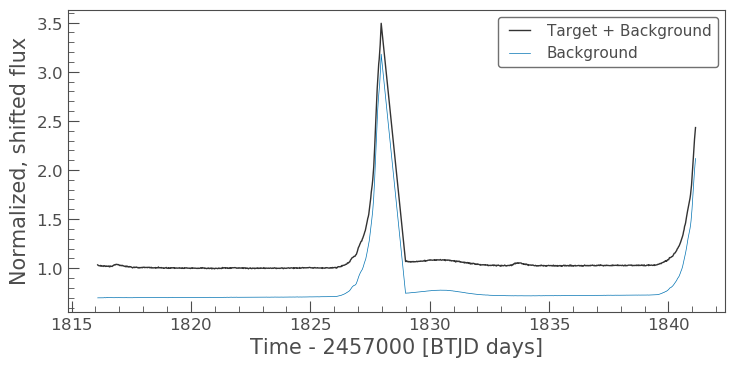

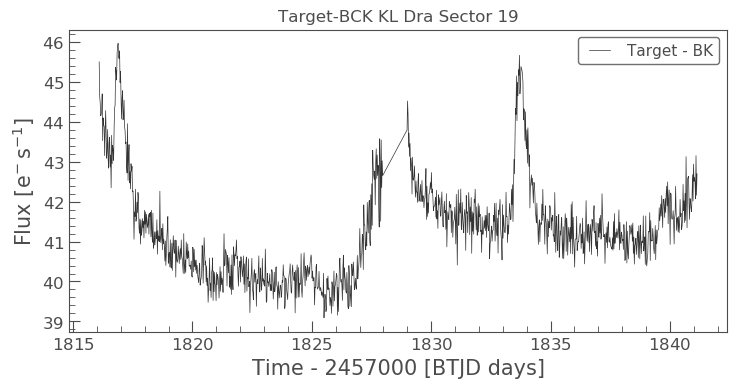

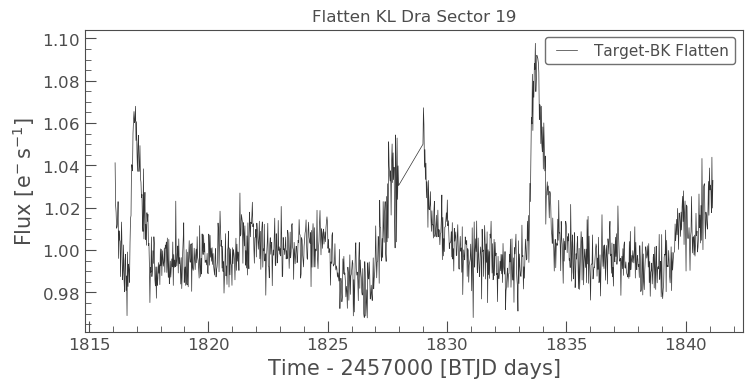

In [117]:
sourcemaskfits = fits.open(sourcelc)
sourcemask = sourcemaskfits[2].data
n_target_pixels = len(np.where(sourcemask==3)[0])

target_lc = tpf.to_lightcurve(aperture_mask=sourcemask)
target_lc.plot(label='Target + Background')
titleplot1 = '{} Sector {}'.format(name,sectornum)
plt.title(titleplot1)


#Backgorund
backgroundmaskfits = fits.open(backgroundlc)
backgroundmask = backgroundmaskfits[2].data
n_background_pixels = len(np.where(backgroundmask==3)[0])
background_lc_per_pixel = tpf.to_lightcurve(aperture_mask=backgroundmask) / n_background_pixels
print("Number of Background Pixels: {}".format(n_background_pixels))
background_estimate_lc = background_lc_per_pixel * n_target_pixels

# Substrtact background
common_normalization = np.nanpercentile(target_lc.flux, 10)
ax = (target_lc / common_normalization).plot(normalize=False, label='Target + Background', lw=1);
(background_estimate_lc / common_normalization +0).plot(ax=ax, normalize=False, label='Background',
                                                        ylabel='Normalized, shifted flux');


corrected_lc = target_lc - background_estimate_lc.flux
corrected_lc.plot(label='Target - BK');
plt.title('Target-BCK {} Sector {}'.format(name,sectornum))


#Remove low frequenbce
flat_lc = corrected_lc.flatten(window_length=401)
flat_lc.plot(label='Target-BK Flatten');
plt.title('Flatten {} Sector {}'.format(name,sectornum))



#Bokeh 
lcdic = {'time':corrected_lc.time,
        "flatflux":corrected_lc.flux}
source = ColumnDataSource(data=lcdic)

p = figure(plot_width=900, plot_height=500,title='Target-BCK {} Sector {}'.format(name,sectornum))
    

#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ('Date', '(@time{0,0.000})')
        ]
    )


p.add_tools(hover2)

p.line('time','flatflux',source=source)
show(p)


In [110]:
sectornum = 19
star = eleanor.Source(coords=(sourcetess['ra'],sourcetess['dec']), sector=sectornum, tc=False)
dataeleanor = eleanor.TargetData(star,height=11, width=11)

SearchError: Sorry, this sector isn't available yet. We're working on it!

In [111]:
timelc = corrected_lc.astropy_time

In [112]:
timelc

<Time object: scale='tdb' format='jd' value=[2458816.09368896 2458816.11450195 2458816.13531494 ... 2458841.09338379
 2458841.11419678 2458841.1350708 ]>

In [113]:
initlc, endlc = timelc[0], timelc[-1]

In [114]:
initlc.iso, endlc.iso

('2019-11-28 14:14:54.727', '2019-12-23 15:14:30.117')

In [115]:
initlc.mjd

58815.593688964844

In [116]:
endlc.mjd

58840.63507080078

# SEctor 20

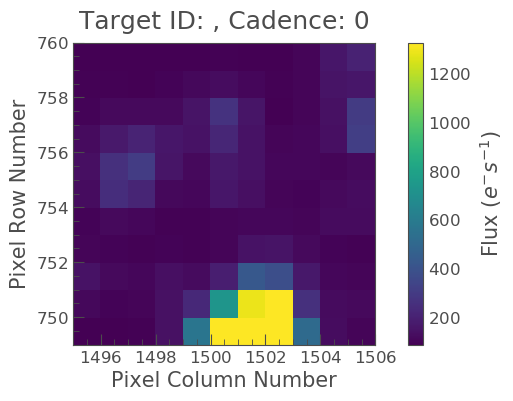

In [139]:
sectornum = 20
#tpf = lk.search_tesscut(sourcecoord,sector=sectornum).download(cutout_size=11)

url = "https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra={ra}&dec={dec}&y=11&x=11&units=px&sector={sector}".format(ra=sourcetess['ra']
,dec=sourcetess['dec']
,sector=sectornum)
#tpf = lk.search_tesscut(sourcecoord,sector=sectornum).download(cutout_size=11)
response = urllib.request.urlretrieve(url,'TESSCUT.zip')
with ZipFile('TESSCUT.zip') as zipobj:
    zipobj.extractall()
    
for i in glob.glob('tess-s*.fits'):
    os.rename(i,'astrocut.fits')
    tpf = lk.TessTargetPixelFile('astrocut.fits')
    os.remove('astrocut.fits')
    os.remove('TESSCUT.zip')
    



tpf.plot()

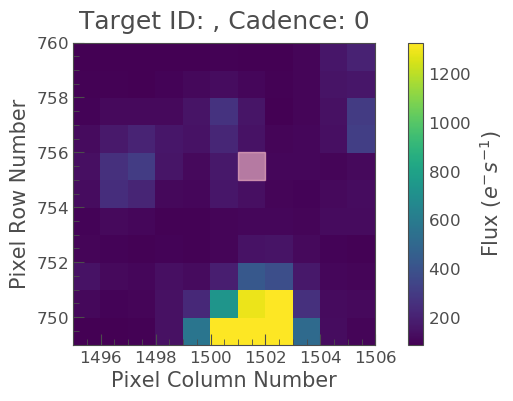

In [140]:
# Guess closest pixel
radecs = np.vstack([[tpf.ra], [tpf.dec]]).T
coords = tpf.wcs.all_world2pix(radecs, 0)

x=coords[:, 0]+tpf.column
x1=coords[:, 0]

y=coords[:, 1]+tpf.row
y1 = coords[:, 1]


masknear = np.zeros([11,11])
masknear[ceil(x1)][ceil(y1)] = 1.
maskneartoplot = masknear.astype(bool)
tpf.plot(aperture_mask=maskneartoplot)

In [141]:
#If eleanor mask was found can do aperture_mask=data.aperture.astype(bool)

sourcelc = '{}Sector{}withBKLC.fits'.format(name,tpf.sector)
#tpf.interact(notebook_url='localhost:8888',exported_filename=sourcelc)
tpf.interact(notebook_url='localhost:8888',exported_filename=sourcelc,aperture_mask=maskneartoplot)

In [142]:
tpf.interact_sky(magnitude_limit=20)

In [143]:
background_mask = ~tpf.create_threshold_mask(threshold=0.0000001, reference_pixel=None)
#tpf.plot(aperture_mask=background_mask, mask_color='w');
n_background_pixels = background_mask.sum()
#print(n_background_pixels)
backgroundlc = '{}Sector{}BKLC.fits'.format(name,tpf.sector)

tpf.interact(notebook_url='localhost:8888',exported_filename=backgroundlc,aperture_mask=background_mask)

## Create a light-curve

Number of Background Pixels: 61


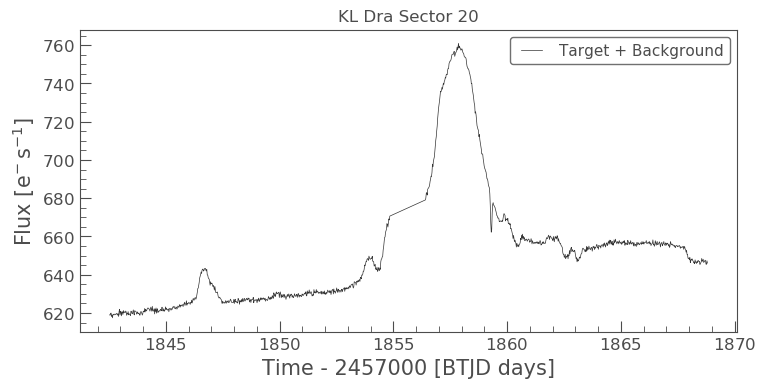

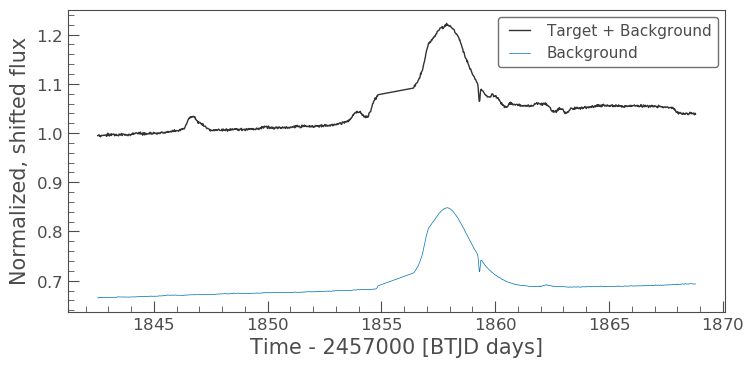

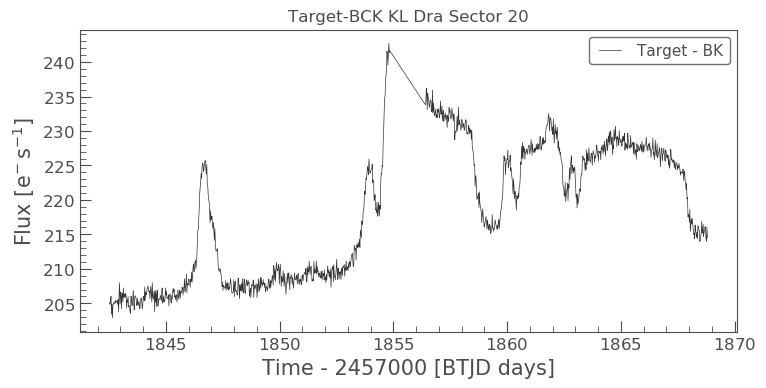

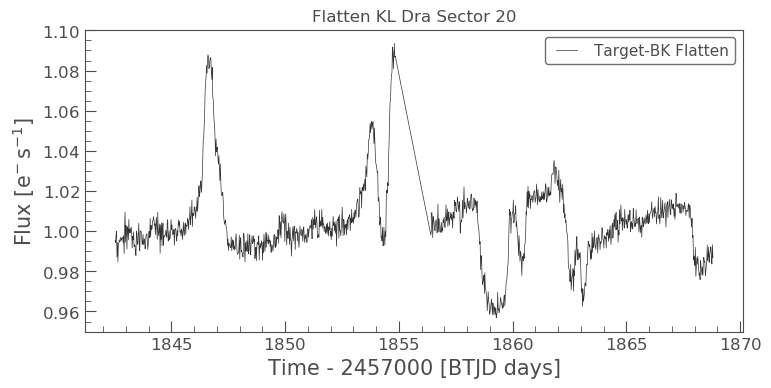

In [144]:
sourcemaskfits = fits.open(sourcelc)
sourcemask = sourcemaskfits[2].data
n_target_pixels = len(np.where(sourcemask==3)[0])

target_lc = tpf.to_lightcurve(aperture_mask=sourcemask)
target_lc.plot(label='Target + Background')
titleplot1 = '{} Sector {}'.format(name,sectornum)
plt.title(titleplot1)


#Backgorund
backgroundmaskfits = fits.open(backgroundlc)
backgroundmask = backgroundmaskfits[2].data
n_background_pixels = len(np.where(backgroundmask==3)[0])
background_lc_per_pixel = tpf.to_lightcurve(aperture_mask=backgroundmask) / n_background_pixels
print("Number of Background Pixels: {}".format(n_background_pixels))
background_estimate_lc = background_lc_per_pixel * n_target_pixels

# Substrtact background
common_normalization = np.nanpercentile(target_lc.flux, 10)
ax = (target_lc / common_normalization).plot(normalize=False, label='Target + Background', lw=1);
(background_estimate_lc / common_normalization +0).plot(ax=ax, normalize=False, label='Background',
                                                        ylabel='Normalized, shifted flux');


corrected_lc = target_lc - background_estimate_lc.flux
corrected_lc.plot(label='Target - BK');
plt.title('Target-BCK {} Sector {}'.format(name,sectornum))


#Remove low frequenbce
flat_lc = corrected_lc.flatten(window_length=401)
flat_lc.plot(label='Target-BK Flatten');
plt.title('Flatten {} Sector {}'.format(name,sectornum))



#Bokeh 
lcdic = {'time':corrected_lc.time,
        "flatflux":corrected_lc.flux,
        "mjdtimelc":corrected_lc.astropy_time.mjd}
source = ColumnDataSource(data=lcdic)

p = figure(plot_width=900, plot_height=500,title='Target-BCK {} Sector {}'.format(name,sectornum))
    

#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ('Date', '(@time{0,0.000})'),
            ("MJD",'(@mjdtimelc{00000.000})')
        ]
    )


p.add_tools(hover2)

p.line('time','flatflux',source=source)
show(p)


In [124]:
timelc = corrected_lc.astropy_time

In [125]:
timelc

<Time object: scale='tdb' format='jd' value=[2458842.53118896 2458842.55200195 2458842.57281494 ... 2458868.7600708
 2458868.78088379 2458868.80169678]>

In [126]:
initlc, endlc = timelc[0], timelc[-1]

In [127]:
print(initlc.mjd,endlc.mjd)

58842.031188964844 58868.301696777344
